* https://github.com/chiang9/Medium_blog/blob/main/Item_based_cf/movielen_item_based_cf.ipynb

## Collaborative Filtering Recommendation System with Item-based Model

__Collaborative Filtering__ is widely used in building recommendation system. There are 2 main approaches in memory-based model, __item-based__ or __user-based__. In practice, we usually have data with more users than the number of items and only a small portion of items get frequent rating, and this situation is called the long tail effect. The long tail effect usually implies the high data sparsity, and sparse data will affect the accuracy of our model.

In order to resolve the high sparsity issue, Item-based model often leads to faster online learning and better recommendation. In contrast, user-based model works better to detect users with special taste.

In this example, we will build a recommendation system using the item-based model. The collaborative filtering method is to predict the rating of specific user on certain items based on the rating of co-rated users or items.



### Dataset
In this example, we will be using the movielens dataset (ml-100k).

source: https://grouplens.org/datasets/movielens/




### Item-based Collaborative Filtering

Item-based collaborative filtering will use the rating of co-rated item to predict the rating on specific item.

For example, we need to predict rating of user 2 on item 2.

|        | user 1 | user 2 | user 3 | user 4 |
|--------|--------|--------|--------|--------|
| item 1 | 3      | 4      | nan    | nan    |
| item 2 | 2      | ?      | 1      | nan    |
| item 3 | nan    | nan    | 2      | 4      |
| item 4 | 2      | 1      | 4      | nan    |

1. Find the co-rated items of user 2, which is item 1 and item 4
2. Calculate the similarity between item 2 and item 1, 4 - $\omega_{2,1}$ and $\omega_{2,4}$
3. Calculate the prediction based on the similarity and co-rated rating, such that
$$prediction_{u,i} = \frac {\sum_{n}\omega_{i,n}*r_{u,n}}{\sum_{n}\left\lvert {\omega_{i,n}}\right\lvert}$$

#### Similarity

There are a lot of methods to calculate the similarity between the items, such as __Jaccard similarity, Pearson correlation__...etc. 

In this example, we will use the __cosine similarity__. 

$$similarity = cos(\theta) = \frac {A \dot B}{\left\lvert\left\lvert A \right\lvert\right\lvert\left\lvert\left\lvert B \right\lvert\right\lvert}$$

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt


In [3]:
train_path = 'data/ml-100k/u1.base'
test_path = 'data/ml-100k/u1.test'

df = pd.read_csv(train_path, delimiter = '\t', names = ['userid', 'itemid', 'rating', 'timestamp'])
df.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [4]:
utility = df.pivot(index = 'itemid', columns = 'userid', values = 'rating')
utility = utility.fillna(0)
utility.head()

userid,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
itemid,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# similarity = 1- distance
distance_mtx = squareform(pdist(utility, 'cosine'))
similarity_mtx = 1- distance_mtx

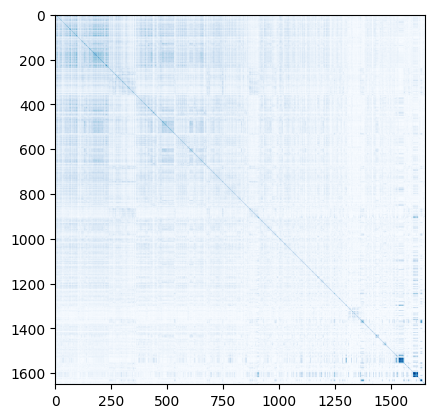

In [6]:
plt.imshow(similarity_mtx, cmap = 'Blues')

As we can see from the plot, the data is sparse

In [7]:
# Let's predict the rating of user2 on item 3
user_to_predict = 2
item_to_predict = 3

user2_ratings = utility.iloc[:,user_to_predict-1]
item3_similarity = similarity_mtx[item_to_predict-1]


In [8]:
numerator = np.dot(user2_ratings,item3_similarity)
denom = item3_similarity[user2_ratings > 0].sum()
prediction = numerator / denom
prediction

np.float64(3.8222849282597053)

Next, we formulate the prediction function into a function

In [9]:
def compute_prediction(userid, itemid, similarity_mtx, utility):
    user_rating = utility.iloc[:,userid-1]
    item_similarity = similarity_mtx[itemid-1]
    numerate = np.dot(user_rating, item_similarity)
    denom = item_similarity[user_rating > 0].sum()
            
    if denom == 0 or numerate == 0:
        return user_rating[user_rating>0].mean()
    
    return numerate / denom

compute_prediction(2,3, similarity_mtx, utility)

np.float64(3.8222849282597053)

We can test our model by using the __RMSE__

In [10]:
test = pd.read_csv(test_path, delimiter = '\t', names = ['userid', 'itemid', 'rating', 'timestamp'])
test_set = test[['userid', 'itemid']].to_numpy()
test_real = test['rating'].to_numpy()

In [11]:
pred = []
for data in test_set:
    res = compute_prediction(data[0], data[1], similarity_mtx, utility)
    pred.append(res)

In [12]:
rmse = np.sqrt(np.mean((test_real - pred)**2))
print(f'RMSE = {rmse}')

RMSE = 1.0452369678411928


### Building the Recommendation System

In order to make the item-based model into a recommendation system, we calculate all ratings of the specific user. For instance, we want to recommend items to user 2, and we calculate all predicted ratings and select the top n items that user 2 might like.

In [13]:
def calculate_user_rating(userid, similarity_mtx, utility):
    user_rating = utility.iloc[:,userid-1]
    pred_rating = deepcopy(user_rating)
    
    default_rating = user_rating[user_rating>0].mean()
    numerate = np.dot(similarity_mtx, user_rating)
    corr_sim = similarity_mtx[:, user_rating >0]
    for i,ix in enumerate(pred_rating):
        temp = 0
        if ix < 1:
            w_r = numerate[i]
            sum_w = corr_sim[i,:].sum()
            if w_r == 0 or sum_w == 0:
                temp = default_rating
            else:
                temp = w_r / sum_w
            pred_rating.iloc[i] = temp
    return pred_rating


def recommendation_to_user(userid, top_n, similarity_mtx, utility):
    user_rating = utility.iloc[:,userid-1]
    pred_rating = calculate_user_rating(userid, similarity_mtx, utility)

    top_item = sorted(range(1,len(pred_rating)), key = lambda i: -1*pred_rating.iloc[i])
    top_item = list(filter(lambda x: user_rating.iloc[x]==0, top_item))[:top_n]
    res = []
    for i in top_item:
        res.append(tuple([i, pred_rating.iloc[i]]))
    
    return res

recommendation_to_user(2,10,similarity_mtx, utility)

[(1398, 4.704560704514258),
 (861, 4.642353328817946),
 (1641, 4.641362312762584),
 (1439, 4.603460311402641),
 (1123, 4.543079741085078),
 (1346, 4.4948279147275025),
 (1560, 4.4948279147275025),
 (1333, 4.45874227212434),
 (774, 4.389151878334362),
 (1530, 4.379045803272321)]